# Modelling

In this section, we will implement Linear Regression and Random Forest Regression to estimate the hourly taxi demand in NYC.
***

## Import Libraries

In [586]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, functions as F
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [398]:
# Starting a Spark session
spk = (
    SparkSession.builder.appName('model')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)


## Split data into training and testing set

In [587]:
# Read the merged and preprocessed dataset
nyc_hourly_demand = spk.read.parquet('../data/curated/combined_data.parquet').toPandas()

# Rename building class C columns as it causes error with the ols function
nyc_hourly_demand.rename({'C':'C_class'}, axis = 1, inplace = True)


Py4JJavaError: An error occurred while calling o70.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 6.0 failed 1 times, most recent failure: Lost task 0.0 in stage 6.0 (TID 6) (10.13.152.199 executor driver): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
# Extract the last month as testing set, the remaining will be our training set
test = nyc_hourly_demand[nyc_hourly_demand['month'] == 4]
train = nyc_hourly_demand[nyc_hourly_demand['month'] != 4]


## Prepare training and testing data for each borough

Based on our preliminary analysis, we saw that daily average demand differed greatly across boroughs, therefore we need to train the model separately on each borough to accurately model the local demand.

In [403]:
# Get all location ids under each borough
borough_id = {}
for borough in nyc_hourly_demand['borough'].unique():
    borough_id[borough] = nyc_hourly_demand[nyc_hourly_demand['borough'] == borough]['pu_location_id'].unique()
    

In [404]:
# Exclude the unnecessary columns
excl_col = ['service_zone','zone','borough', 'geometry']


In [405]:
# Split the data into features and target
X_train = train[[col for col in nyc_hourly_demand.columns if col not in ['count'] + excl_col]]
Y_train = train['count']

X_test = test[[col for col in nyc_hourly_demand.columns if col not in ['count'] + excl_col]]
Y_test = test['count']


In [425]:
# Get XYtrain, XYtest data for each boroughs separately
borough_data = {bor:[] for bor in borough_id.keys()}
for bor in borough_id.keys():
    
    # Find the indices of all records that belong to the borough
    train_idx = X_train[X_train['pu_location_id'].isin(borough_id[bor])].index
    test_idx = X_test[X_test['pu_location_id'].isin(borough_id[bor])].index
    
    # Extract the XYtrain and XYtest based on the indices above
    borough_data[bor].extend([X_train[X_train.index.isin(train_idx)],
                              Y_train[Y_train.index.isin(train_idx)], 
                              X_test[X_test.index.isin(test_idx)], 
                              Y_test[Y_test.index.isin(test_idx)]])
    

In [426]:
len(X_train.columns)

33

## Train and estimate using Linear Regression model on each borough data

Here we will fit a linear model on the training data of each borough and using the model to predict the test data of the borough.

In [409]:
# Get all unique categorical levels for the categorical features
uniq_month = nyc_hourly_demand['month'].unique()
uniq_hour = nyc_hourly_demand['pickup_hour'].unique()
uniq_dayweek = nyc_hourly_demand['day_of_week'].unique()

# Train LinearRegressor on each borough data
lr_equation_1 = ('count ~ C(pu_location_id) + C(month, levels=uniq_month) +' +
                 '+ C(day_of_week, levels=uniq_dayweek) + C(is_weekday)' +
                 'C(pickup_hour, levels=uniq_hour) + temperature + dew_point + atmospheric_pressure +' +
                 '+ A + B + C_class + V + S + D + K + O + M + G + W + E + N + P + F + Z + U + Q + ' +
                 'H + Y + I + R + J + T + total_lot')


borough_lr_model = {bor: ols(lr_equation_1, 
                             data=pd.concat([borough_data[bor][0], borough_data[bor][1]], axis=1),
                             missing='drop').fit() \
                 for bor in borough_id.keys()}


In [570]:
# Obtain Linear Regression predictions
borough_lr_pred = {}
for bor in borough_id.keys():
    borough_lr_pred[bor] = borough_lr_model[bor].predict(borough_data[bor][2])
    
    # Make sure there are no negative prediction
    borough_lr_pred[bor][borough_lr_pred[bor] < 0] = 0

    

In [571]:
# RMSE of the Linear Regression predictions
print("RMSE of the Linear Regression model:")
for bor in borough_id.keys():
    print(f"  {bor}: {np.sqrt(mean_squared_error(borough_data[bor][3], borough_lr_pred[bor])):.2f}")
    

RMSE of the Linear Regression model:
  Manhattan: 44.98
  Queens: 33.72
  Brooklyn: 1.80
  Bronx: 0.58
  Staten Island: 1.49
  EWR: 15.24


## Train and estimate using Random Forest Regression model on each borough data

Here we will fit the Random Forest Regressor on the training data of each borough and using the model to predict the test data of the borough. However, before we train the model, we need to tune the hyperparameter to ensure optimum performance of the model.

In [416]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None, verbose=0):
    '''
    Given a set of hyperparameters, return the model that produces the most optimal result
    based on the scoring function.
    '''
    if score_func:
        gs = GridSearchCV(clf, 
                          param_grid=parameters, 
                          cv=n_folds, 
                          n_jobs=n_jobs, 
                          scoring=score_func, 
                          verbose=verbose)
    else:
        # Use default scoring function
        gs = GridSearchCV(clf, 
                          param_grid=parameters, 
                          n_jobs=n_jobs, 
                          cv=n_folds, 
                          verbose=verbose)
    
    gs.fit(X, y)
    
    print("BEST", gs.best_params_, gs.best_score_)
    print("Best score: ", gs.best_score_)
    
    best = gs.best_estimator_
    
    return best


Due to the long computation time, we decided to tune the hyperparameter using the entire training data instead of spliting into different boroughs. For 5 boroughs, we need to run $5^2*3^3=675$ iterations (including the 5-fold cv) to find the optimal configurations compared to the $135$ iterations if we were to run the GridSearch on the whole training data set. We will therefore use this result to approximate the optimal configurations for each of the model.

In [418]:
# Hyperparameter tuning for the Random Forest Regression model on the training data
# parameters = {"n_estimators": [10,50,100],
#               "max_features": ["auto",'sqrt','log2'],
#               "max_depth": [10,50,70]}

# best = cv_optimize(RFR, 
#                    parameters, 
#                    X_train, 
#                    Y_train, 
#                    n_folds=5, 
#                    score_func='neg_root_mean_squared_error', 
#                    verbose=3)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-73.807 total time=  14.3s
[CV 2/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-80.922 total time=  15.4s
[CV 3/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-58.882 total time=  16.9s
[CV 4/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-41.526 total time=  15.3s
[CV 5/5] END max_depth=10, max_features=auto, n_estimators=10;, score=-43.551 total time=  13.3s
[CV 1/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-72.642 total time= 1.0min
[CV 2/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-80.073 total time= 1.1min
[CV 3/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-59.756 total time= 1.1min
[CV 4/5] END max_depth=10, max_features=auto, n_estimators=50;, score=-41.590 total time= 1.1min
[CV 5/5] END max_depth=10, max_features=auto, n_estimators=50;, s

[CV 5/5] END max_depth=50, max_features=log2, n_estimators=50;, score=-33.114 total time=  27.9s
[CV 1/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-71.090 total time=  50.4s
[CV 2/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-60.643 total time=  50.3s
[CV 3/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-37.909 total time=  52.8s
[CV 4/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-34.366 total time=  50.8s
[CV 5/5] END max_depth=50, max_features=log2, n_estimators=100;, score=-30.565 total time=  52.8s
[CV 1/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-71.406 total time=  22.3s
[CV 2/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-78.843 total time=  23.9s
[CV 3/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-60.051 total time=  24.0s
[CV 4/5] END max_depth=70, max_features=auto, n_estimators=10;, score=-38.753 total time=  23.5s
[CV 5/5] END max_depth=70

Based on our 135 iterations of GridSearchCV, the most optimal hyperparameters for the model is:
- max_depth: 70
- max_features: sqrt
- n_estimators: 100

In [572]:
# Train and predict RandomForestRegressor on each borough test data
borough_rfr_model = {bor: RandomForestRegressor(max_depth=70, max_features='sqrt', n_estimators=100) \
                 for bor in borough_id.keys()}
borough_rfr_pred = {}

for bor in borough_id.keys():
    borough_rfr_model[bor].fit(borough_data[bor][0], borough_data[bor][1])
    borough_rfr_pred[bor] = borough_rfr_model[bor].predict(borough_data[bor][2])
    
    # Make sure there are no negative prediction
    borough_rfr_pred[bor][borough_rfr_pred[bor] < 0] = 0
    

In [573]:
# RMSE of the RandomForestRegressor predictions
print("RMSE of the Random Forest Regression model:")
for bor in borough_id.keys():
    print(f"{bor}: {np.sqrt(mean_squared_error(borough_data[bor][3], borough_rfr_pred[bor])):.2f}")
    

RMSE of the Random Forest Regression model:
Manhattan: 20.45
Queens: 16.07
Brooklyn: 1.59
Bronx: 0.58
Staten Island: 1.46
EWR: 16.96


## Plot the average of predicted daily demand between the two models in April 2022 for Manhattan

In [574]:
borough_test_data_idx = {bor:borough_data[bor][2].index for bor in borough_id.keys()}

In [579]:
# Combine the predicted data with the original test data
manhat_pred = nyc_hourly_demand.iloc[borough_test_data_idx['Manhattan']][['count','pickup_hour','day_of_week']]
manhat_pred = pd.concat([manhat_pred, 
                         borough_lr_pred['Manhattan']],
                        axis=1).rename({0:'lr_pred_count'}, axis=1)

manhat_pred = pd.concat([manhat_pred, 
                         pd.Series(borough_rfr_pred['Manhattan'], index=borough_test_data_idx['Manhattan'])],
                        axis=1).rename({0:'rfr_pred_count'}, axis=1)


In [580]:
manhat_pred

,count,pickup_hour,day_of_week,lr_pred_count,rfr_pred_count
4,170,9,5,136.024151,141.77
5,127,9,1,123.973827,114.64
6,157,18,2,170.034351,147.29
7,24,4,4,70.784206,42.39
8,144,7,4,114.466004,135.77
...,...,...,...,...,...
439968,1,12,5,16.354555,1.01
439976,1,12,3,10.783615,1.02
439983,1,12,6,17.936819,1.03
439986,1,4,1,0.000000,1.97


In [584]:
manhat_pred_1 = (manhat_pred.groupby('pickup_hour')
                          .agg({'count':'sum',
                                'lr_pred_count':'sum',
                                'rfr_pred_count':'sum'})
                          .reset_index())

# manhat_pred_1[['count', 'lr_pred_count', 'rfr_pred_count']] = manhat_pred_1[['count', 'lr_pred_count', 'rfr_pred_count']] / 30


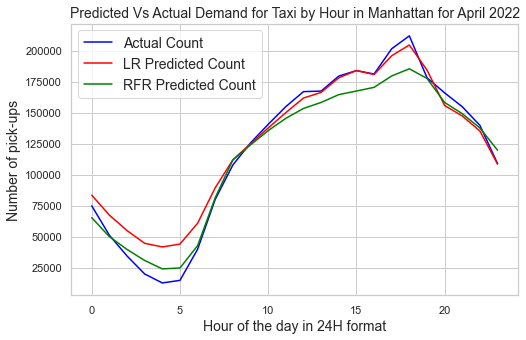

In [585]:
sns.set(style='whitegrid', palette='pastel', color_codes=True)
fig, ax = plt.subplots(1, figsize=(8,5))

sns.lineplot(x='pickup_hour', y='count', data=manhat_pred_1, color='blue')
sns.lineplot(x='pickup_hour', y='lr_pred_count', data=manhat_pred_1, color='red')
sns.lineplot(x='pickup_hour', y='rfr_pred_count', data=manhat_pred_1, color='green')

plt.xlabel('Hour of the day in 24H format', fontsize=14)
plt.ylabel('Number of pick-ups', fontsize=14)
plt.legend(['Actual Count','LR Predicted Count','RFR Predicted Count'], fontsize=14)
plt.title('Predicted Vs Actual Demand for Taxi by Hour in Manhattan for April 2022', fontsize=14)
plt.savefig('../plots/predicted_trend.png', dpi=300, bbox_inches='tight')